In [1]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys
import geopandas as gpd
from matplotlib import pyplot as plt

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'

img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X'
array_pickles = funcoes.ler_diretorios(pickle_dir)
vetor_informacoes = []

tracados = f'{root_dir}/Artificial_Lines/tracados_bezier/{img_especifica}_savedata_1.json'
array_medial_path = backgen.retorna_paths(tracados)

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))

for i in range(len(array_medial_path)):  
  n_random = np.random.randint(0, len(array_pickles), size=1) 
  print(n_random)
  path = (pickle_dir + f'/{array_pickles[n_random[0]]}') 
  print(path)
  arquivo_pickle = pickle.load(open(path, 'rb'))
  #print(array_pickles)
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values,
  imagem_binaria_original = vessel_map.mapped_mask_values
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)
  rows, cols = mapa_original[0].shape
  limiar = backgen.encontrar_pixel_mais_frequente(mapa_original[0])
  distancia = (rows/2)
  caminhos_transladados = backgen.retorna_caminhos_transladados(array_medial_path[i],0) # type: ignore
  maior_valor = np.max(caminhos_transladados[0])
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original[0],maior_valor)
  vaso_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor)  
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original": imagem_binaria_original,
      "imagem_binaria_sem_artefatos_laterais": imagem_binaria_sem_artefatos_laterais,  
      "imagem_binaria_sem_artefatos": imagem_binaria_sem_artefatos,
      "caminhos_transladados": caminhos_transladados,
      "maior_valor": maior_valor,
      "mapa_expandido_original": mapa_expandido_original,
      "vaso_expandido_bin": vaso_expandido_bin,
      "rows": rows,
      "cols": cols,
      "distancia": distancia,
      "limiar": limiar
    }
  vetor_informacoes.append(dict)

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))
img_merged = back_artif
vetor_mapas_sem_artefatos = []
vetor_mapas_originais = []
vetor_vasos_sem_artefados = []
vetor_mask_map = []

for i in range(len(array_medial_path)):    

    caminhos_transladados = vetor_informacoes[i]['caminhos_transladados'] # type: ignore
    maior_valor = vetor_informacoes[i]['maior_valor'] # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
    mapa_original = vetor_informacoes[i]['mapa_original'] # type: ignore
    imagem_binaria_sem_artefatos = vetor_informacoes[i]['imagem_binaria_sem_artefatos'] # type: ignore
    mapa_expandido_original = vetor_informacoes[i]['mapa_expandido_original'] # type: ignore
    vaso_expandido_bin = vetor_informacoes[i]['vaso_expandido_bin'] # type: ignore     
    vessel_map = vetor_informacoes[i]['vessel_map'] # type: ignore
    limiar = vetor_informacoes[i]['limiar'] # type: ignore 
   
    linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)
    dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)
    img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_expandido_original,dst_array_np,maior_tamanho)
    mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)
    mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,array_medial_path[i],img_out)
    vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
    mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)
    img_out_bin = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
    vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)   

    vetor_vasos_sem_artefados.append(vaso_sem_artefatos)
    vetor_mapas_sem_artefatos.append(mapa_sem_artefatos)
    vetor_mask_map.append(mask_map)
    vetor_mapas_originais.append(mapa_original[0])

    point_random = np.random.randint(100, 1000, size=1)
    point = (point_random[0],point_random[0])
    #img_merged = backgen.inserindo_vaso_fundo2(mapa_sem_artefatos,vaso_sem_artefatos,img_merged,point,limiar)

    #img_merged = backgen.inserindo_vaso_fundo2(vetor_mapas_sem_artefatos[i], vetor_vasos_sem_artefados[i], back_artif, (0,0), limiar)
    

img = img_merged.copy()

[48]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 4-20X_savedata4.pickle
[9]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 2-20X_savedata2.pickle
[9]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@41-Image 2-20X_savedata2.pickle
[31]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 4-20X_savedata1.pickle
[30]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@74-Image 2-20X_savedata0.pickle
[41]
/home/adriano/projeto_mestrado/modules/Vessel_Models_pickle/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata4.pickle
[16]
/home/adriano/projeto_mestrado/modules/Vessel_Mod

/tmp/ipykernel_1748114/4291145070.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)
/tmp/ipykernel_1748114/4291145070.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_originais),i+1)


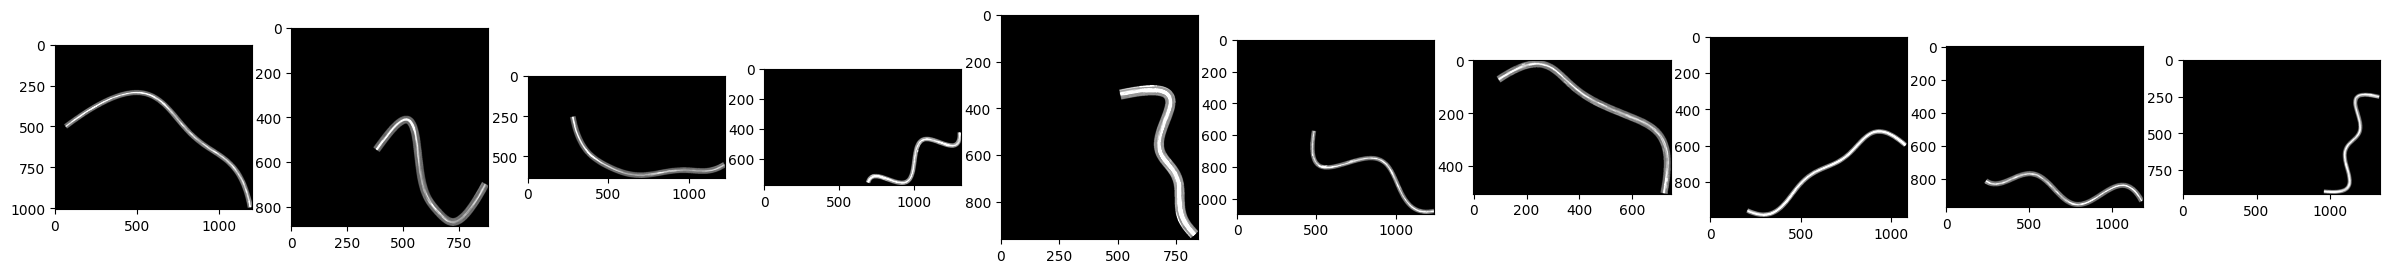

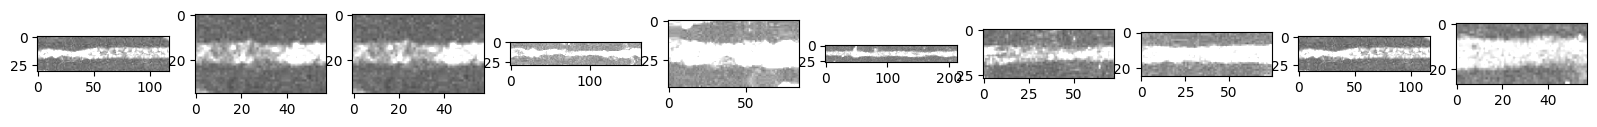

In [ ]:

# plt.figure(figsize=[10, 8])
# plt.title("fundo com vaso")
# plt.imshow(img, 'gray', vmin=0, vmax=60)
# plt.plot()

plt.figure(figsize=[30, 30])
plt.title("mapa_sem_artefatos")
for i in range(len(vetor_mapas_sem_artefatos)):  
    plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)  
    plt.imshow(vetor_mapas_sem_artefatos[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[20, 16])
plt.title("Mapas originais")
for i in range(len(vetor_mapas_originais)):  
    plt.subplot(1,len(vetor_mapas_originais),i+1)  
    plt.imshow(vetor_mapas_originais[i], 'gray', vmin=0, vmax=60)



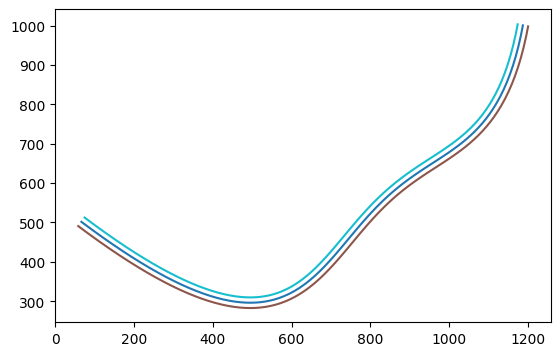

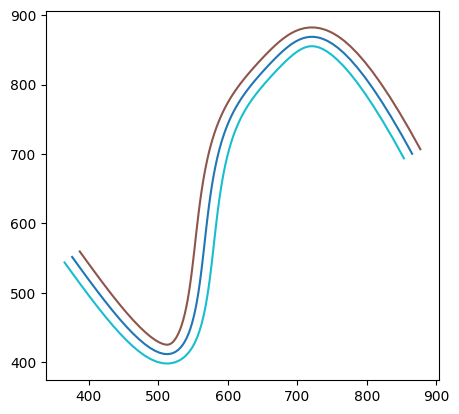

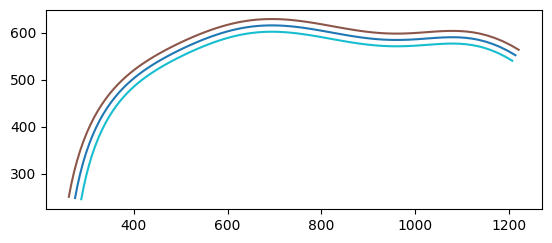

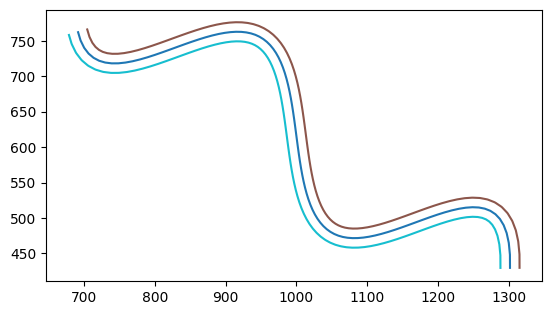

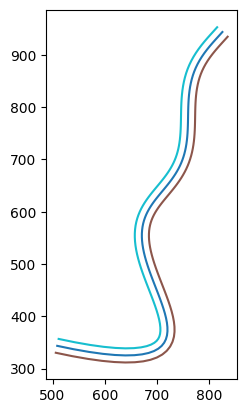

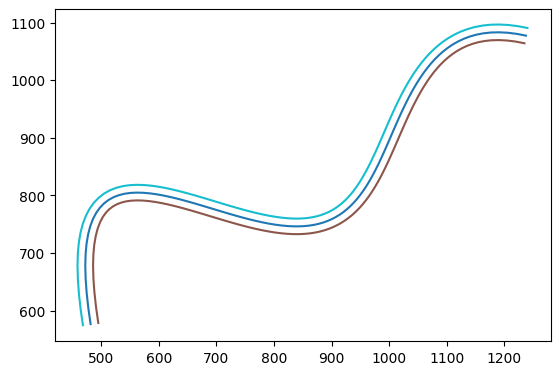

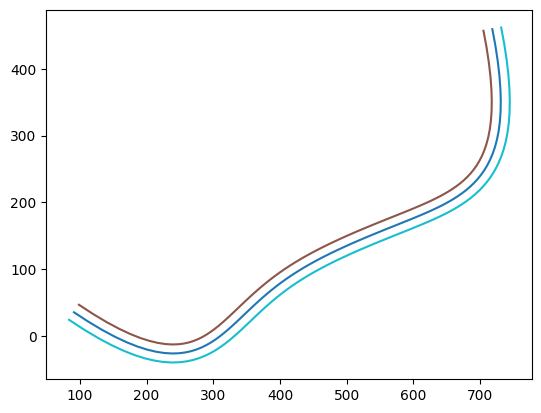

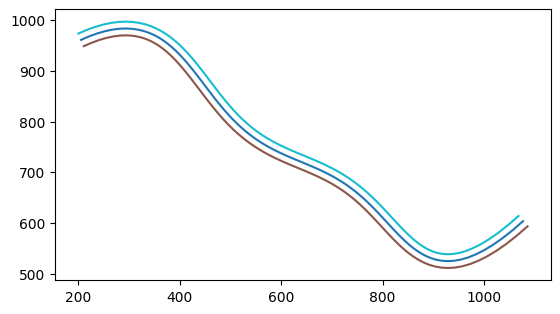

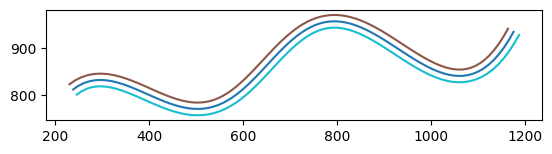

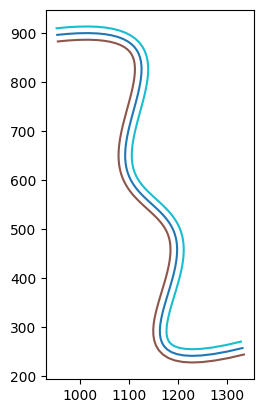

In [6]:
for i in range(len(array_medial_path)):    
    #caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_medial_path[i], 2) # type: ignore

    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)

    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
    gp4.plot(cmap="tab10")





[]

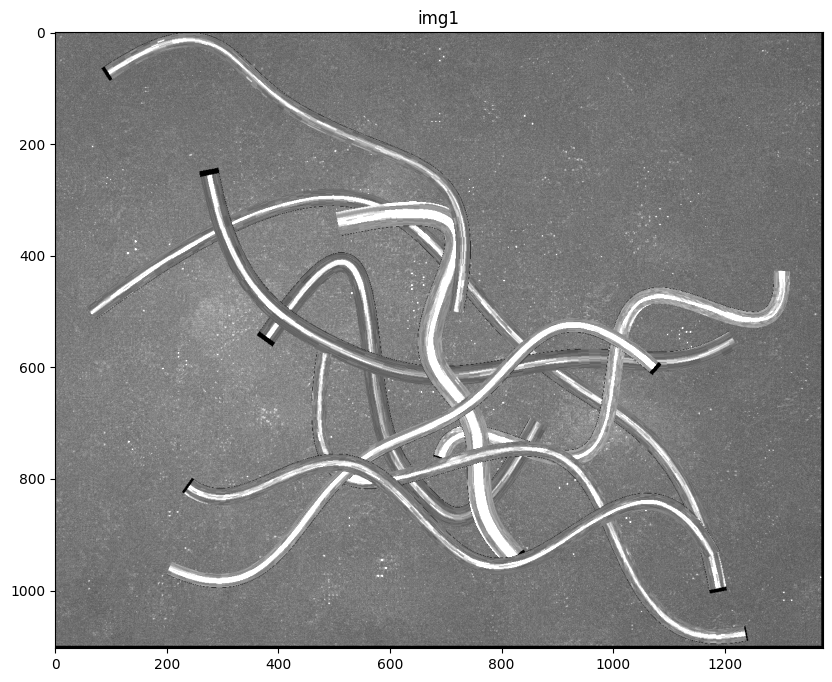

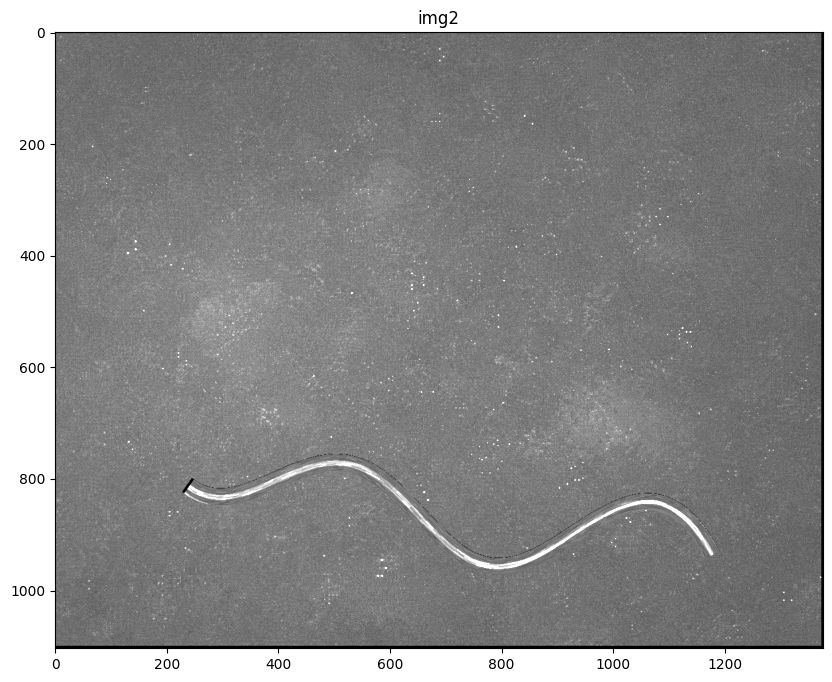

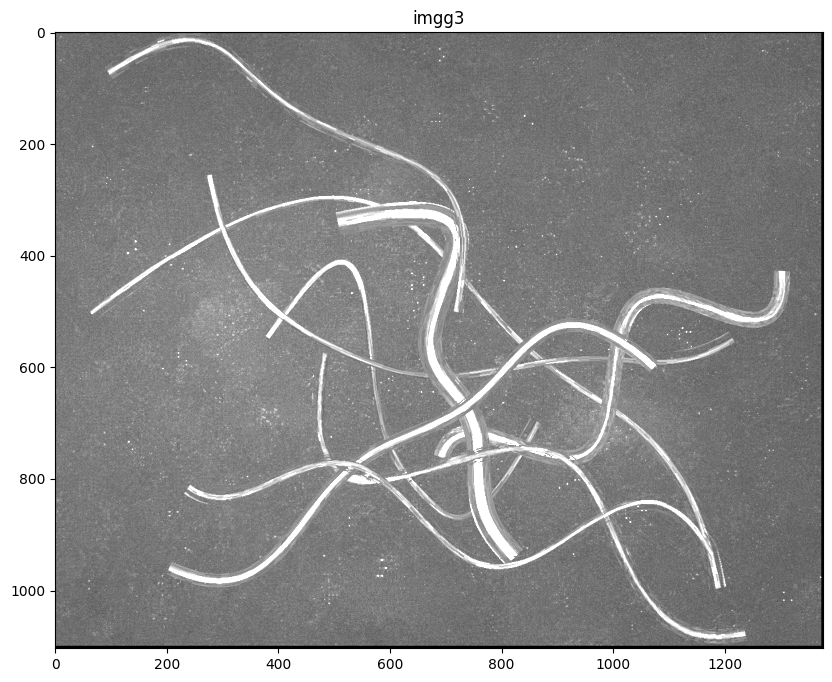

In [7]:
 
back_artif1 = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))


for i in range(9):
    img1 = backgen.inserindo_vaso_no_fundo(vetor_mapas_sem_artefatos[i], vetor_mask_map[i], back_artif1, (0,0))

back_artif2 = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))

for i in range(9):
    img2 = backgen.inserindo_vaso_fundo2(vetor_mapas_sem_artefatos[i], vetor_mask_map[i], back_artif2, (0,0), 30)   

back_artif3 = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))

vet_img = []
img3 = back_artif3.copy()
for i in range(9):   
    img3 = backgen.inserindo_vaso_fundo2(vetor_mapas_sem_artefatos[i], vetor_vasos_sem_artefados[i], img3, (0,0), 30)
    

# vet = np.concatenate((vet_img[0],vet_img[1]))
# for vet in vet_img:

    

plt.figure(figsize=[10, 8])
plt.title("img1")
plt.imshow(img1, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("img2")
plt.imshow(img2, 'gray', vmin=0, vmax=60)
plt.plot()


plt.figure(figsize=[10, 8])
plt.title("imgg3")
plt.imshow(img3, 'gray', vmin=0, vmax=60)
plt.plot()

# plt.figure(figsize=[10, 8])
# plt.title("vet")
# plt.imshow(vet, 'gray', vmin=0, vmax=60)
# plt.plot()

In [5]:
import PIL
from PIL import Image


img1 = Image.fromarray(vet_img[0])
img2 = Image.fromarray(vet_img[1])


mask = Image.new("L", img1.size,1)

#teste = Image.blend(img1,img2,alpha=0.5)
teste = Image.composite(img1,img2,mask)

teste.show()

IndexError: list index out of range

In [ ]:
plt.figure(figsize=[10, 8])
plt.title("teste")
plt.imshow(teste, 'gray', vmin=0, vmax=60)
plt.plot()